In [1]:
import deepxde as dde
import numpy as np
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
dde.config.set_random_seed(1234)

### 1. Specify the computational domain using the geometry module.

In [6]:
geom = dde.geometry.Interval(0, 1)

timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

### 2. Specify the PDE using the grammar of TensorFlow.

In [7]:
v = 0.05

def pde(x, u):
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - v * du_xx + u * du_x

### 3. Specify the boundary and/or initial conditions.

In [8]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

ic = dde.icbc.IC(geomtime, lambda x: np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

### 4. Combine the geometry, PDE and boundary/initial conditions together into data.PDE or data.TimePDE.

In [9]:
data = dde.data.TimePDE(geomtime, 
                        pde, 
                        [bc, ic],
                        num_domain=2500, 
                        num_boundary=500, 
                        num_initial=200)

### 5. Construct a neural network using the maps module.

In [10]:
net = dde.nn.FNN([2] + [110] * 3 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

### 6. Define a Model by combining the PDE problem in Step 4 and the neural netin Step 5.

In [12]:
model = dde.Model(data, net)

### 7. Call Model.compile to set the optimization hyperparameters, such as optimizer and learning rate.

### 8. Call Model.train to train the network from random initialization.

In [13]:
model.compile("adam", lr=0.001)
losshistory, train_state =model.train(iterations=10000)
model.compile("L-BFGS-B")
losshistory1, train_state1 =model.train(iterations=15000)

Compiling model...
Building feed-forward neural network...

'build' took 0.159485 s



C:\anaconda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(



'compile' took 0.538985 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.55e-02, 2.30e-01, 8.71e-01]    [4.55e-02, 2.30e-01, 8.71e-01]    []  
1000      [5.95e-03, 2.05e-03, 3.91e-03]    [5.95e-03, 2.05e-03, 3.91e-03]    []  
2000      [7.14e-04, 4.02e-04, 2.07e-04]    [7.14e-04, 4.02e-04, 2.07e-04]    []  
3000      [3.38e-04, 1.47e-04, 8.89e-05]    [3.38e-04, 1.47e-04, 8.89e-05]    []  
4000      [1.48e-03, 1.62e-04, 1.19e-04]    [1.48e-03, 1.62e-04, 1.19e-04]    []  
5000      [1.76e-04, 5.20e-05, 2.55e-05]    [1.76e-04, 5.20e-05, 2.55e-05]    []  
6000      [1.69e-04, 3.82e-05, 1.88e-05]    [1.69e-04, 3.82e-05, 1.88e-05]    []  
7000      [1.56e-04, 3.25e-05, 1.11e-05]    [1.56e-04, 3.25e-05, 1.11e-05]    []  
8000      [1.14e-04, 2.04e-05, 8.88e-06]    [1.14e-04, 2.04e-05, 8.88e-06]    []  
9000      [1.91e-03, 1.58e-04, 1.11e-04]    [1.91e-03, 1.58e-04, 1.11e-04]    []  
10000     [2.16e-04, 4.59e-05, 8.

In [141]:
import scipy

data = scipy.io.loadmat("C:/Users/charl/Downloads/burgers_shock.mat")
    
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
    
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]    

In [132]:
u_exact_list1 = []
x_list = np.arange(-1,1.01,0.01)

for x in x_list:
    u_exact_list1.append(u_exact(x,0,10))

In [133]:
u_exact_list2 = []
x_list = np.arange(-1,1.01,0.01)

for x in x_list:
    u_exact_list2.append(u_exact(x,0.4,10))

In [134]:
u_exact_list3 = []
x_list = np.arange(-1,1.01,0.01)

for x in x_list:
    u_exact_list3.append(u_exact(x,0.9,10))

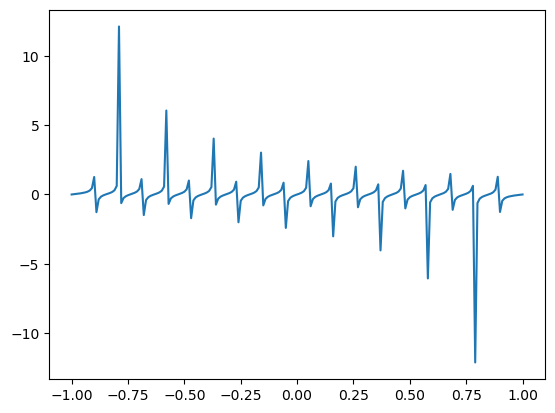

In [135]:
plt.plot(x_list,u_exact_list1)
#plt.plot(x_list,u_exact_list2)
#plt.plot(x_list,u_exact_list3)
#plt.plot(x_list,u_predict,'--')

In [48]:
t_test = np.full(shape=(len(x_list),), fill_value=0.5).reshape(len(x_list),1)
x_test = x_list.reshape(len(x_list),1)
test = np.concatenate([x_test,t_test],axis=1)

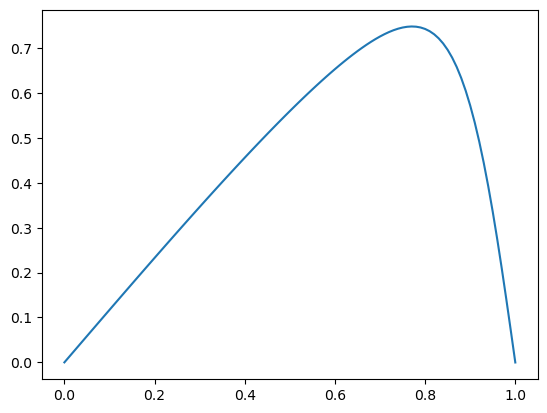

In [208]:
u_predict = model.predict(test)
plt.plot(x_list,u_predict)

In [ ]:
u_predict = model.predict(test)
u1_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u1_exact, u1.T))

In [ ]:
X = geomtime.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

### 9. Call Model.predict to predict the PDE solution at different locations.

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [18]:
A=1
m=1
def u_exact(x, y): 
    return (A*np.sinh(m*np.pi*y)/np.sinh(m*np.pi))*np.sin(m*np.pi*x)

In [19]:
u1 = model1.predict(data1.train_x_all)
u1_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u1_exact, u1.T))

0.00089154363


In [20]:
u2 = model2.predict(data1.train_x_all)
u2_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u2_exact, u2.T))

0.00097396265


In [21]:
u3 = model3.predict(data1.train_x_all)
u3_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u3_exact, u3.T))

0.0040592356


In [22]:
u4 = model4.predict(data1.train_x_all)
u4_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u4_exact, u4.T))

0.003632985


In [23]:
u5 = model5.predict(data1.train_x_all)
u5_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u5_exact, u5.T))

0.0007681666


In [24]:
u6 = model6.predict(data1.train_x_all)
u6_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u6_exact, u6.T))

0.0012854278


In [25]:
u7 = model7.predict(data1.train_x_all)
u7_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u7_exact, u7.T))

0.0033876963


In [30]:
u8 = model8.predict(data1.train_x_all)
u8_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u8_exact, u8.T))

0.00062875793


In [31]:
u9 = model9.predict(data1.train_x_all)
u9_exact = u_exact(data1.train_x_all.T[0],data1.train_x_all.T[1])
print(dde.metrics.l2_relative_error(u9_exact, u9.T))

0.0010601288


In [32]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

In [33]:
font = {'family': 'Arial',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

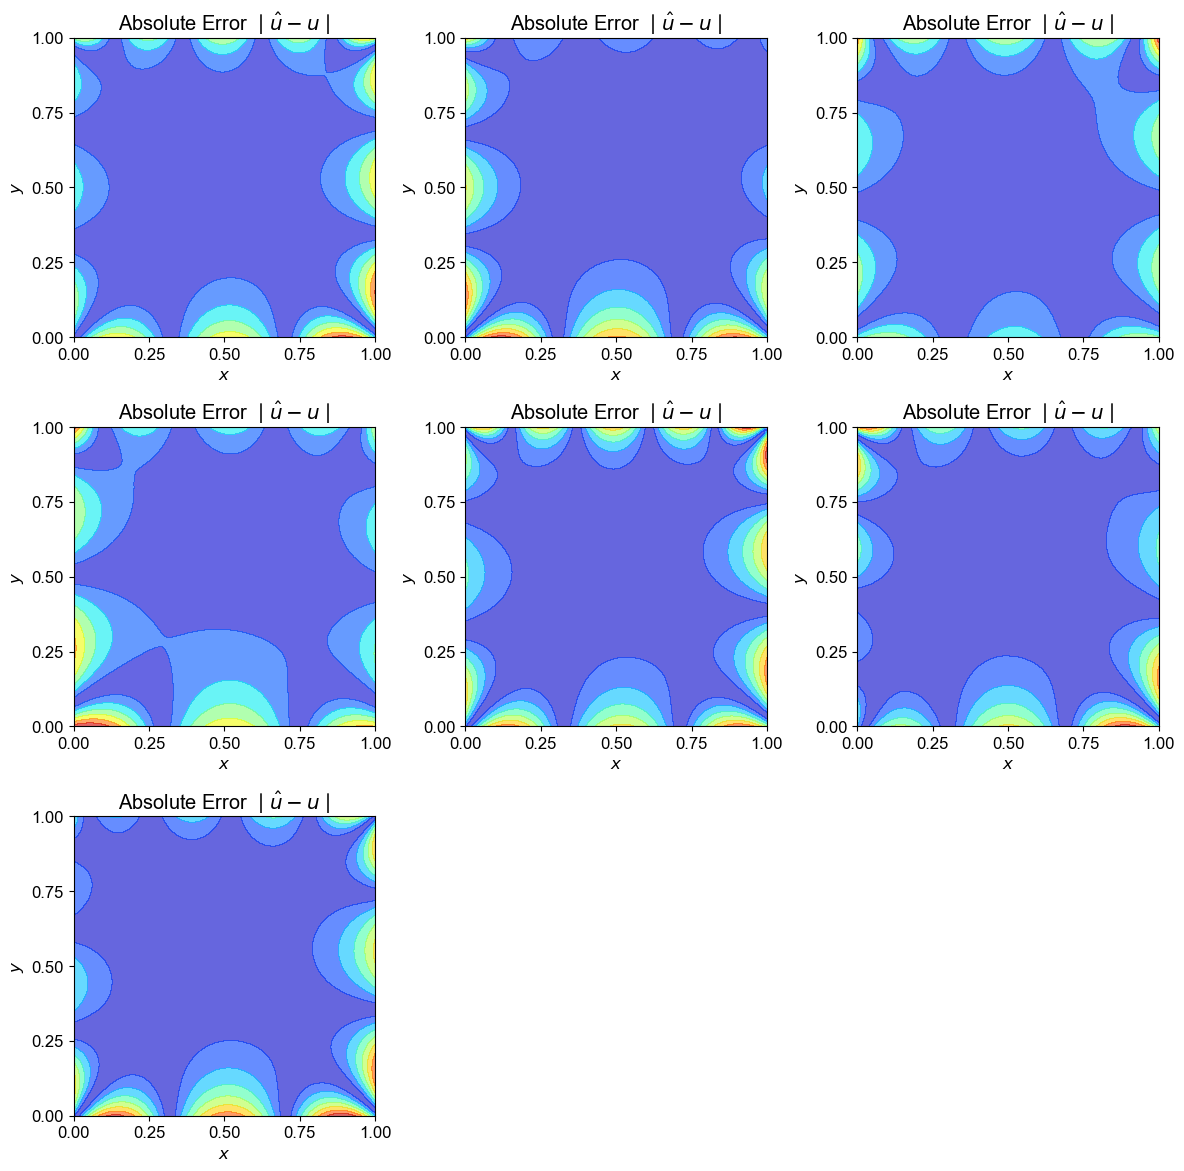

In [60]:
fig = plt.figure(figsize=(14,14))

#plt.suptitle("500-1000 hPa Thickness", y = 0.70, fontsize=19)

#IMAGE 1
ax1 = fig.add_subplot(3,3,1)
u1 = model1.predict(points.T)
u1 = u1.reshape((Nx,Ny))
u1_exact = u_exact(points[0],points[1])
u1_exact = u1_exact.reshape((Nx,Ny))
ax1.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u1-u1_exact), cmap='jet', alpha=0.6)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_xticks([0,0.25,0.5,0.75,1])
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 2
ax2 = fig.add_subplot(3,3,2)
u2 = model2.predict(points.T)
u2 = u2.reshape((Nx,Ny))
ax2.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u2-u1_exact), cmap='jet', alpha=0.6)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_xticks([0,0.25,0.5,0.75,1])
ax2.set_yticks([0,0.25,0.5,0.75,1])
ax2.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 3
ax3 = fig.add_subplot(3,3,3)
u3 = model3.predict(points.T)
u3 = u3.reshape((Nx,Ny))
ax3.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u3-u1_exact), cmap='jet', alpha=0.6)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_xticks([0,0.25,0.5,0.75,1])
ax3.set_yticks([0,0.25,0.5,0.75,1])
ax3.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 2
ax4 = fig.add_subplot(3,3,4)
u4 = model4.predict(points.T)
u4 = u4.reshape((Nx,Ny))
ax4.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u4-u1_exact), cmap='jet', alpha=0.6)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$y$')
ax4.set_xticks([0,0.25,0.5,0.75,1])
ax4.set_yticks([0,0.25,0.5,0.75,1])
ax4.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 2
ax5 = fig.add_subplot(3,3,5)
u5 = model5.predict(points.T)
u5 = u5.reshape((Nx,Ny))
ax5.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u5-u1_exact), cmap='jet', alpha=0.6)
ax5.set_xlabel('$x$')
ax5.set_ylabel('$y$')
ax5.set_xticks([0,0.25,0.5,0.75,1])
ax5.set_yticks([0,0.25,0.5,0.75,1])
ax5.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 2
ax6 = fig.add_subplot(3,3,6)
u8 = model8.predict(points.T)
u8 = u8.reshape((Nx,Ny))
ax6.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u8-u1_exact), cmap='jet', alpha=0.6)
ax6.set_xlabel('$x$')
ax6.set_ylabel('$y$')
ax6.set_xticks([0,0.25,0.5,0.75,1])
ax6.set_yticks([0,0.25,0.5,0.75,1])
ax6.set_title('Absolute Error $\mid \hat{u}-u \mid$');

#IMAGE 2
ax7 = fig.add_subplot(3,3,7)
u9 = model9.predict(points.T)
u9 = u9.reshape((Nx,Ny))
ax7.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u9-u1_exact), cmap='jet', alpha=0.6)
ax7.set_xlabel('$x$')
ax7.set_ylabel('$y$')
ax7.set_xticks([0,0.25,0.5,0.75,1])
ax7.set_yticks([0,0.25,0.5,0.75,1])
ax7.set_title('Absolute Error $\mid \hat{u}-u \mid$');




#fig.colorbar(im, orientation='vertical')

plt.subplots_adjust(hspace=0.3, wspace=0.3)

#plt.savefig("4x128_abserror_bc1.png", bbox_inches = 'tight')

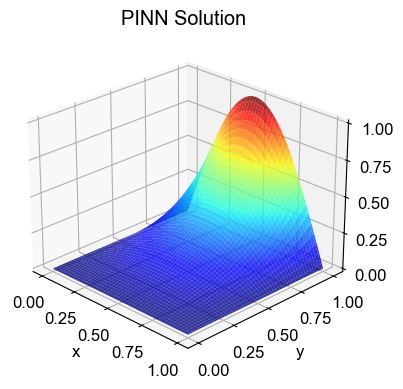

In [232]:
plt.figure(figsize=(4.5,4.5))
ax = plt.axes(projection='3d')

u6 = model6.predict(points.T)
u6 = u6.reshape((Nx,Ny))
ax.plot_surface(plot_grid[0], plot_grid[1], u6, cmap='jet',linewidth=0, alpha = 0.8, zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_2
ax.view_init(*init_view)
ax.set_title('PINN Solution', pad=-20)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_zticks([0,0.25,0.5,0.75,1])

plt.savefig("4x128_pinn_bc1.png", bbox_inches = 'tight')

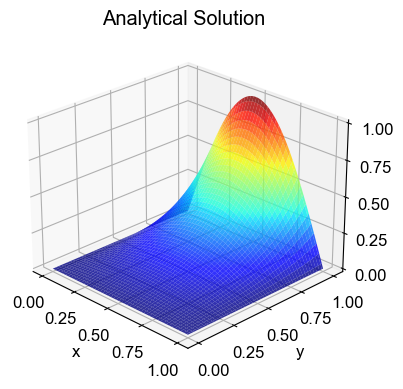

In [233]:
plt.figure(figsize=(4.5,4.5))
ax = plt.axes(projection='3d')

u6_exact = u_exact(points[0],points[1])
u6_exact = u6_exact.reshape((Nx,Ny))
ax.plot_surface(plot_grid[0], plot_grid[1], u6_exact, cmap='jet',linewidth=0, alpha = 0.8, zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_2
ax.view_init(*init_view)
ax.set_title('Analytical Solution', pad=-20)
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_zticks([0,0.25,0.5,0.75,1])

plt.savefig("4x128_analytical_bc1.png", bbox_inches = 'tight')

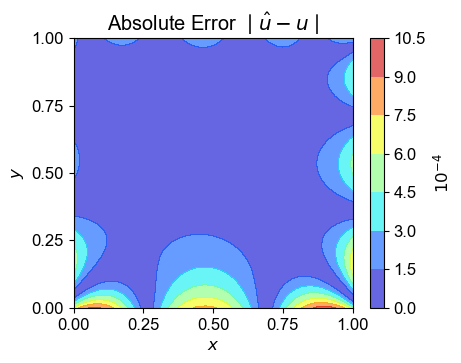

In [235]:
plt.figure(figsize=(4.5,3.5))
u6 = model6.predict(points.T)
u6 = u6.reshape((Nx,Ny))
u6_exact = u_exact(points[0],points[1])
u6_exact = u6_exact.reshape((Nx,Ny))
plt.contourf(plot_grid[0], plot_grid[1], 10000*np.abs(u6-u6_exact), cmap='jet', alpha=0.6)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xticks([0,0.25,0.5,0.75,1])
plt.yticks([0,0.25,0.5,0.75,1])
plt.title('Absolute Error $\mid \hat{u}-u \mid$');
plt.colorbar(label='$10^{-4}$')
plt.savefig("4x128_abserror_bc1.png", bbox_inches = 'tight')

# Reload the model

In [35]:
model1.restore("testsave.ckpt-11189.ckpt", verbose=1)

Restoring model from testsave.ckpt-11189.ckpt ...

INFO:tensorflow:Restoring parameters from testsave.ckpt-11189.ckpt


In [14]:
u_exact = u_exact(points[0],points[1])

u1 = model1.predict(points.T)
u2 = model2.predict(points.T)
u3 = model3.predict(points.T)
u4 = model4.predict(points.T)
u5 = model5.predict(points.T)
u6 = model6.predict(points.T)
u7 = model7.predict(points.T)
u8 = model8.predict(points.T)
u9 = model9.predict(points.T)
u10 = model10.predict(points.T)

In [15]:
np.mean([dde.metrics.l2_relative_error(u_exact, u1.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u2.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u3.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u4.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u5.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u6.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u7.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u8.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u9.reshape(u_exact.shape)),
         dde.metrics.l2_relative_error(u_exact, u10.reshape(u_exact.shape))])

0.2176985683926282

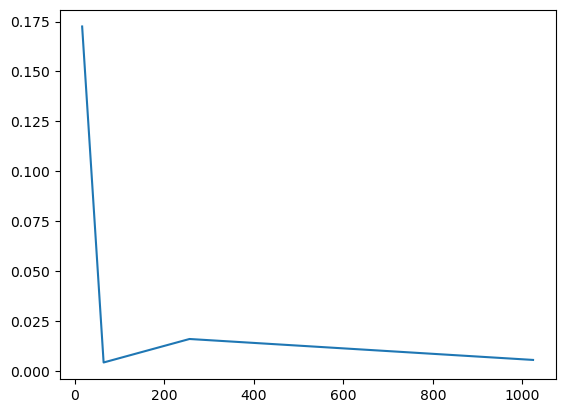

In [21]:
layers = np.array([4*4,8*8,16*16,32*32])

l2_error1 = np.array([dde.metrics.l2_relative_error(u_exact, u1_1.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u2_1.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u3_1.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u4_1.reshape(u_exact.shape))])

plt.plot(layers, l2_error1)

## 10. Training loss vs epochs

In [19]:
total_loss1 = []

for i in range(len(losshistory1.loss_train)):
    total_loss1.append(np.sum(losshistory1.loss_train[i]))

total_loss2 = []

for i in range(len(losshistory2.loss_train)):
    total_loss2.append(np.sum(losshistory2.loss_train[i]))

total_loss3 = []

for i in range(len(losshistory3.loss_train)):
    total_loss3.append(np.sum(losshistory3.loss_train[i]))

total_loss4 = []

for i in range(len(losshistory4.loss_train)):
    total_loss4.append(np.sum(losshistory4.loss_train[i]))

total_loss5 = []

for i in range(len(losshistory5.loss_train)):
    total_loss5.append(np.sum(losshistory5.loss_train[i]))

total_loss6 = []

for i in range(len(losshistory6.loss_train)):
    total_loss6.append(np.sum(losshistory6.loss_train[i]))

total_loss7 = []

for i in range(len(losshistory7.loss_train)):
    total_loss7.append(np.sum(losshistory7.loss_train[i]))

total_loss8 = []

for i in range(len(losshistory8.loss_train)):
    total_loss8.append(np.sum(losshistory8.loss_train[i]))

total_loss9 = []

for i in range(len(losshistory9.loss_train)):
    total_loss9.append(np.sum(losshistory9.loss_train[i]))

total_loss10 = []

for i in range(len(losshistory10.loss_train)):
    total_loss10.append(np.sum(losshistory10.loss_train[i]))

total_loss11 = []

for i in range(len(losshistory11.loss_train)):
    total_loss11.append(np.sum(losshistory11.loss_train[i]))

total_loss12 = []

for i in range(len(losshistory12.loss_train)):
    total_loss12.append(np.sum(losshistory12.loss_train[i]))

In [20]:
epochs = np.array([1,2,3,4,5,6,7,8,9,10])

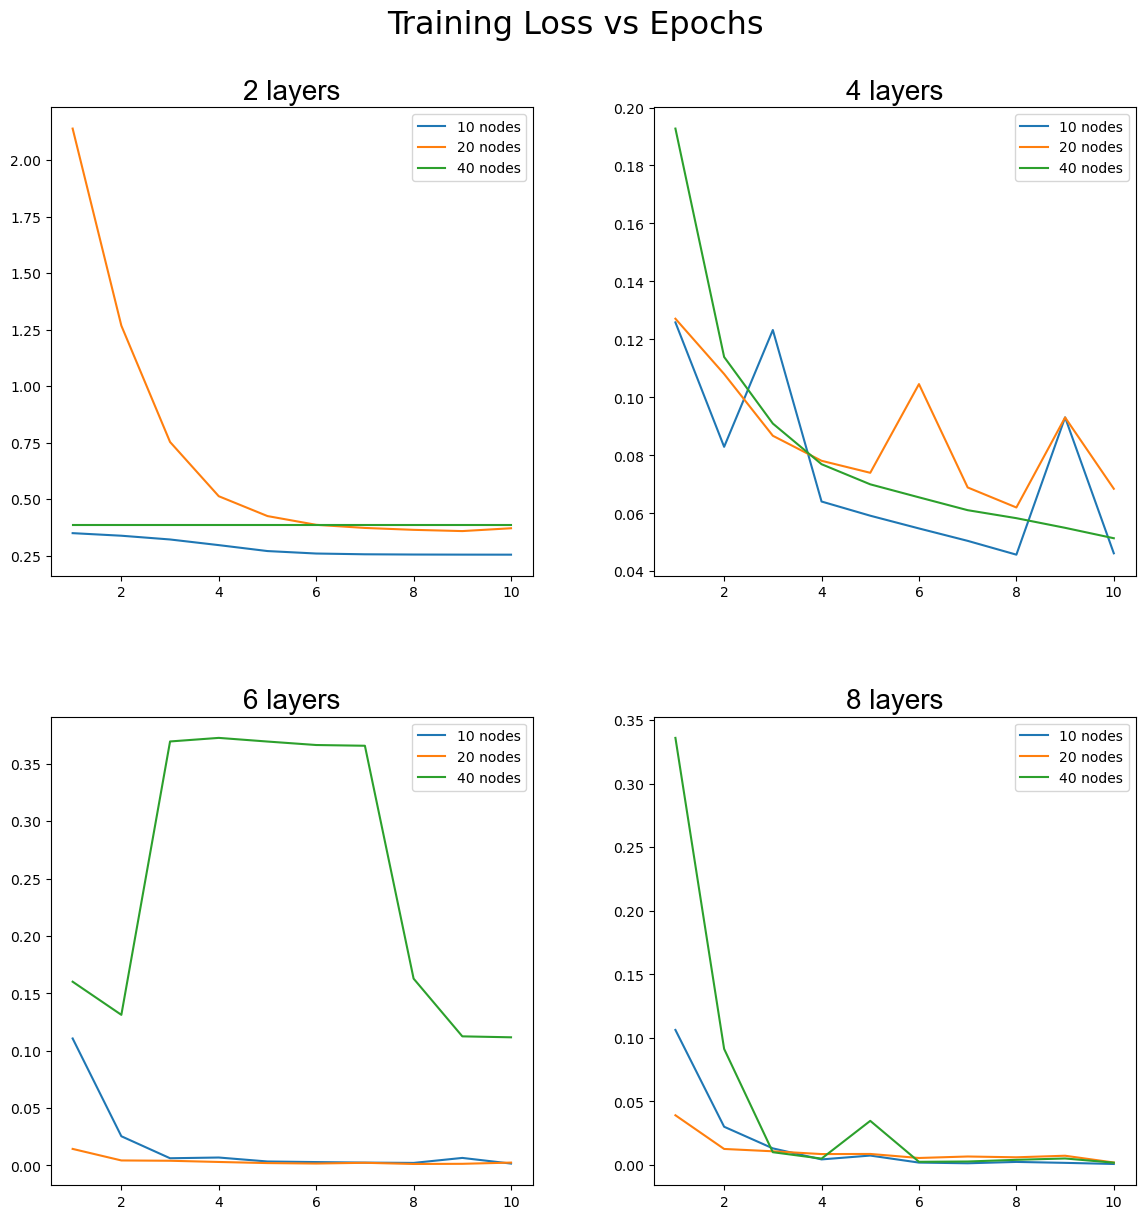

In [21]:
fig = plt.figure(figsize=(14,14))

plt.suptitle("Training Loss vs Epochs", y = 0.95, fontsize=23)

#IMAGE 1
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("2 layers", fontname='Arial', fontsize=20)
ax1.plot(epochs, total_loss1[1:])
ax1.plot(epochs, total_loss2[1:])
ax1.plot(epochs, total_loss3[1:])
ax1.legend(['10 nodes','20 nodes','40 nodes'])

#IMAGE 2
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("4 layers", fontname='Arial', fontsize=20)
ax2.plot(epochs, total_loss4[1:])
ax2.plot(epochs, total_loss5[1:])
ax2.plot(epochs, total_loss6[1:])
ax2.legend(['10 nodes','20 nodes','40 nodes'])

#IMAGE 3
ax3 = fig.add_subplot(2,2,3)
ax3.set_title("6 layers", fontname='Arial', fontsize=20)
ax3.plot(epochs, total_loss7[1:])
ax3.plot(epochs, total_loss8[1:])
ax3.plot(epochs, total_loss9[1:])
ax3.legend(['10 nodes','20 nodes','40 nodes'])

#IMAGE 4
ax4 = fig.add_subplot(2,2,4)
ax4.set_title("8 layers", fontname='Arial', fontsize=20)
ax4.plot(epochs, total_loss10[1:])
ax4.plot(epochs, total_loss11[1:])
ax4.plot(epochs, total_loss12[1:])
ax4.legend(['10 nodes','20 nodes','40 nodes'])

plt.subplots_adjust(hspace=0.3, wspace=0.25)

#plt.savefig("june_msl_z.png")

## 11. Training error vs network architecture

In [36]:
nodes = np.array([10,20,40])

l2_error1 = np.array([dde.metrics.l2_relative_error(u_exact, u1.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u2.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u3.reshape(u_exact.shape))])

l2_error2 = np.array([dde.metrics.l2_relative_error(u_exact, u4.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u5.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u6.reshape(u_exact.shape))])

l2_error3 = np.array([dde.metrics.l2_relative_error(u_exact, u7.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u8.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u9.reshape(u_exact.shape))])

l2_error4 = np.array([dde.metrics.l2_relative_error(u_exact, u10.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u11.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u12.reshape(u_exact.shape))])

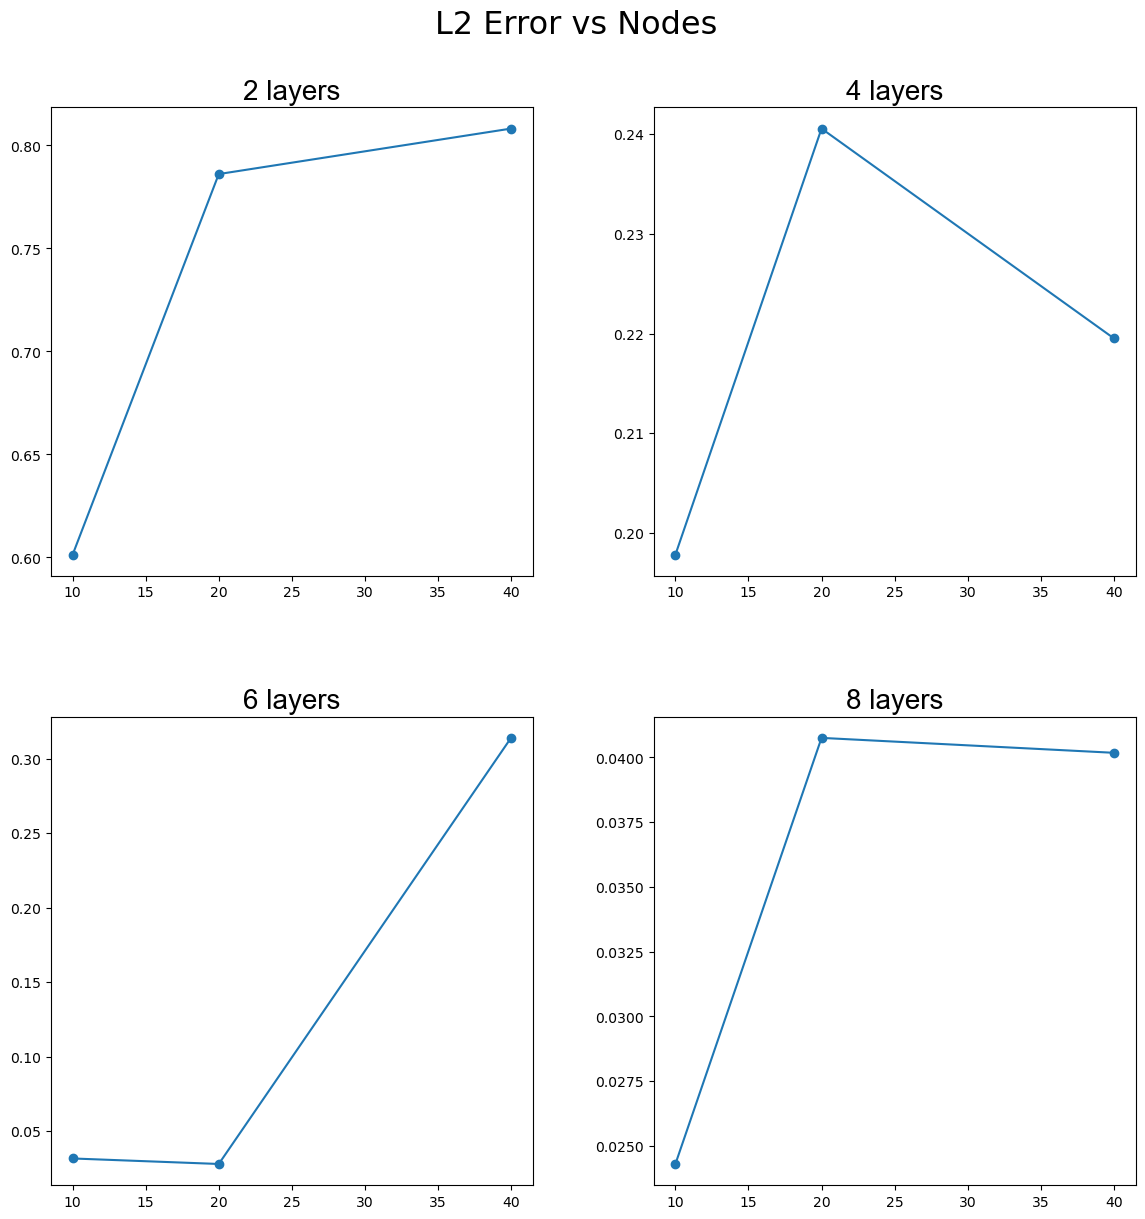

In [37]:
fig = plt.figure(figsize=(14,14))

plt.suptitle("L2 Error vs Nodes", y = 0.95, fontsize=23)

#IMAGE 1
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("2 layers", fontname='Arial', fontsize=20)
ax1.scatter(nodes, l2_error1)
ax1.plot(nodes, l2_error1)

#IMAGE 2
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("4 layers", fontname='Arial', fontsize=20)
ax2.scatter(nodes, l2_error2)
ax2.plot(nodes, l2_error2)

#IMAGE 3
ax3 = fig.add_subplot(2,2,3)
ax3.set_title("6 layers", fontname='Arial', fontsize=20)
ax3.scatter(nodes, l2_error3)
ax3.plot(nodes, l2_error3)

#IMAGE 4
ax4 = fig.add_subplot(2,2,4)
ax4.set_title("8 layers", fontname='Arial', fontsize=20)
ax4.scatter(nodes, l2_error4)
ax4.plot(nodes, l2_error4)

plt.subplots_adjust(hspace=0.3, wspace=0.25)

#plt.savefig("june_msl_z.png")

In [20]:
layers = np.array([3,6,9,12])

l2_error1 = np.array([dde.metrics.l2_relative_error(u_exact, u1.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u5.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u9.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u13.reshape(u_exact.shape))])

l2_error2 = np.array([dde.metrics.l2_relative_error(u_exact, u2.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u6.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u10.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u14.reshape(u_exact.shape))])

l2_error3 = np.array([dde.metrics.l2_relative_error(u_exact, u3.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u7.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u11.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u15.reshape(u_exact.shape))])

l2_error4 = np.array([dde.metrics.l2_relative_error(u_exact, u4.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u8.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u12.reshape(u_exact.shape)),
                      dde.metrics.l2_relative_error(u_exact, u16.reshape(u_exact.shape))])

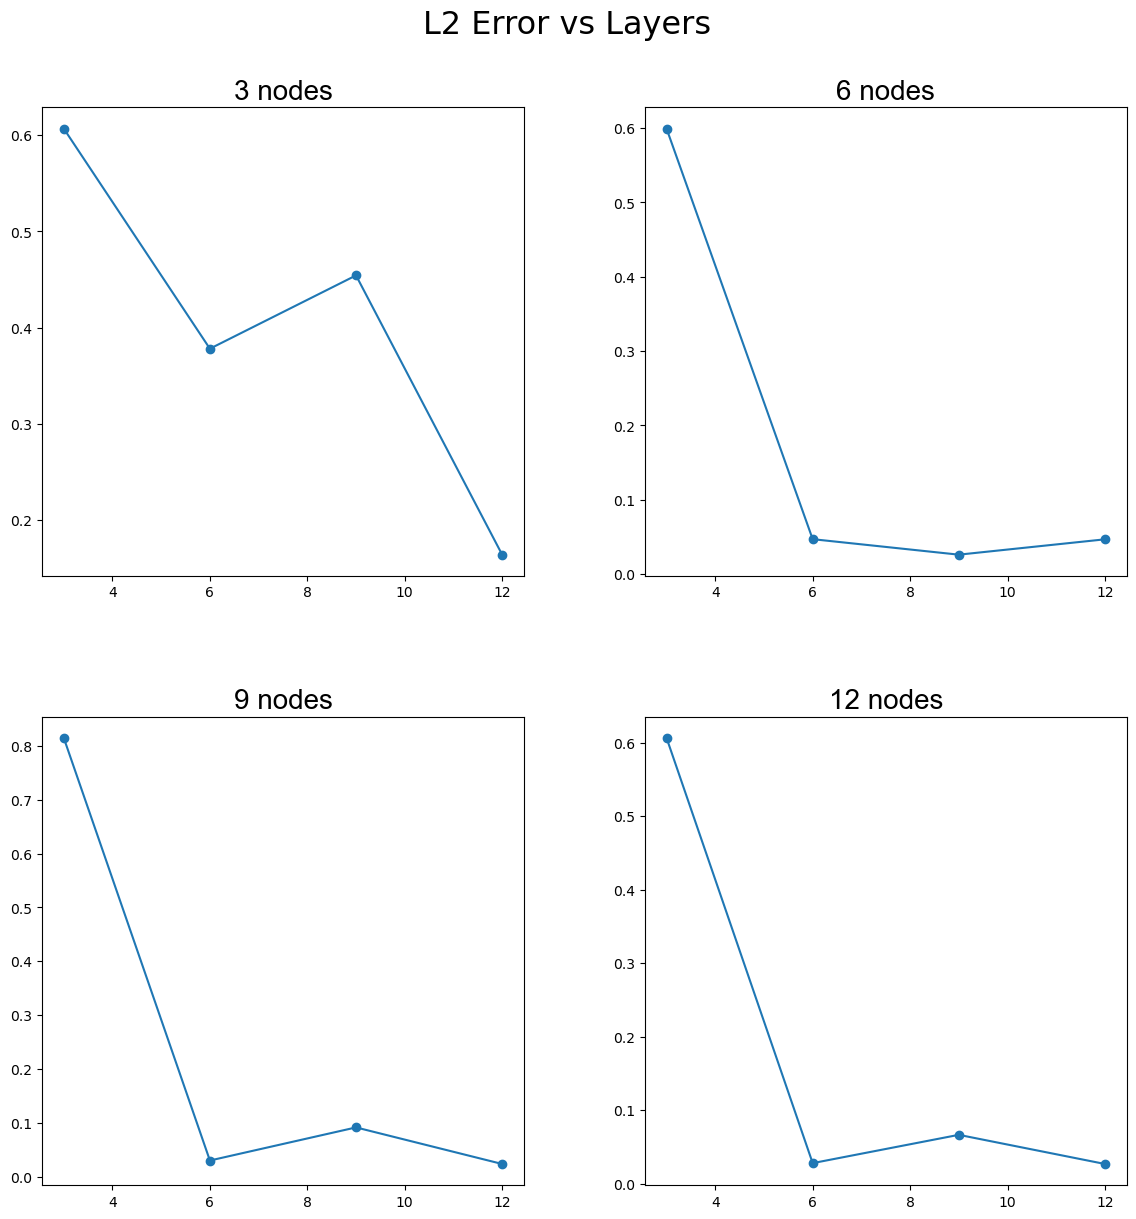

In [21]:
fig = plt.figure(figsize=(14,14))

plt.suptitle("L2 Error vs Layers", y = 0.95, fontsize=23)

#IMAGE 1
ax1 = fig.add_subplot(2,2,1)
ax1.set_title("3 nodes", fontname='Arial', fontsize=20)
ax1.scatter(layers, l2_error1)
plt.plot(layers, l2_error1)

#IMAGE 2
ax2 = fig.add_subplot(2,2,2)
ax2.set_title("6 nodes", fontname='Arial', fontsize=20)
ax2.scatter(layers, l2_error2)
plt.plot(layers, l2_error2)

#IMAGE 3
ax3 = fig.add_subplot(2,2,3)
ax3.set_title("9 nodes", fontname='Arial', fontsize=20)
ax3.scatter(layers, l2_error3)
plt.plot(layers, l2_error3)

#IMAGE 3
ax4 = fig.add_subplot(2,2,4)
ax4.set_title("12 nodes", fontname='Arial', fontsize=20)
ax4.scatter(layers, l2_error4)
plt.plot(layers, l2_error4)


plt.subplots_adjust(hspace=0.3, wspace=0.25)

#plt.savefig("june_msl_z.png")

## 11. Network size vs training set size

## 12. Stepsize vs epochs

Saving loss history to C:\Users\charl\College\acm40980\acm40980_code\loss.dat ...
Saving training data to C:\Users\charl\College\acm40980\acm40980_code\train.dat ...
Saving test data to C:\Users\charl\College\acm40980\acm40980_code\test.dat ...


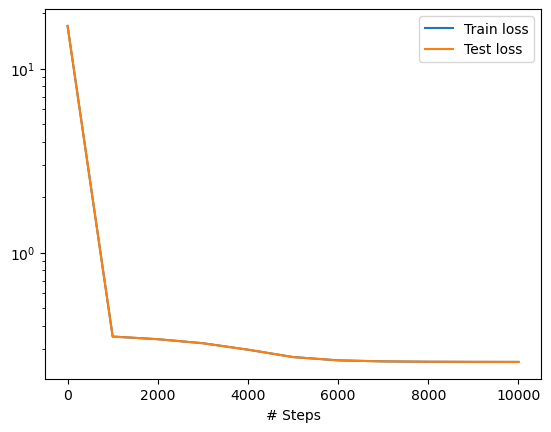

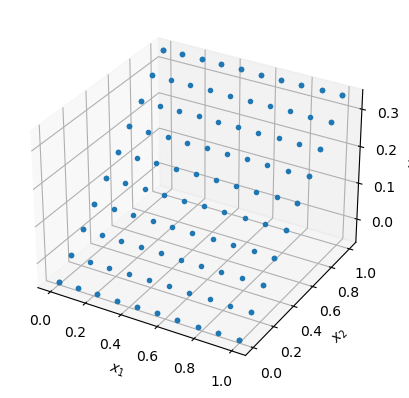

In [14]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [15]:
# Plot the solution over a square grid
Nx = 10
Ny = 10

# Grid points
xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

u = model.predict(points.T)
u = u.reshape((Nx, Ny))

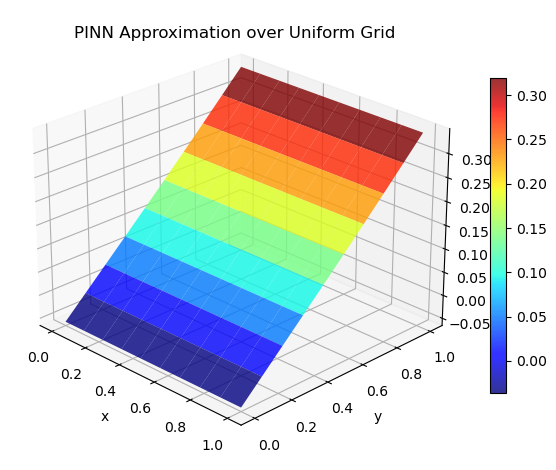

In [16]:
#create 3d axes
fig = plt.figure()
ax = plt.axes(projection='3d')

#Plot the surface.
surf = ax.plot_surface(plot_grid[0], plot_grid[1], u, cmap='jet',linewidth=0, alpha = 0.8, zorder=1)

ax.set_xlabel('x')
ax.set_ylabel('y')

view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_2
ax.view_init(*init_view)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.7, location='right', pad=0.05)

fig.tight_layout()
#plt.gca().axes.xaxis.set_ticklabels([])
#plt.gca().axes.yaxis.set_ticklabels([])
#plt.gca().axes.zaxis.set_ticklabels([])
#plt.grid(alpha = 0.2)

ax.set_title('PINN Approximation over Uniform Grid', pad=-20)

ax.tick_params(axis='x', bottom=False) 

#plt.savefig('pinn_finite_10000.pdf', bbox_inches='tight', dpi=300)

In [23]:
u_pred = model.predict(points.T)
print("L2 relative error:", dde.metrics.l2_relative_error(u_exact, u.reshape(u_exact.shape)))

L2 relative error: 0.601289809115876


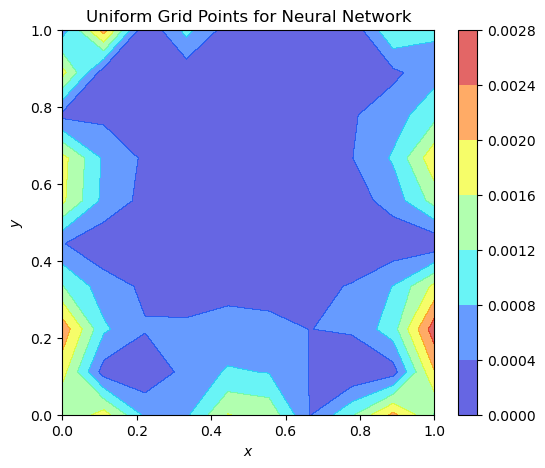

In [37]:
plt.figure(figsize=(6,5))

plt.contourf(plot_grid[0], plot_grid[1], np.abs(u.reshape((Nx, Ny))-u_exact.reshape((Nx, Ny))), cmap='jet', alpha=0.6)

plt.xlabel('$x$')
plt.ylabel('$y$')
#plt.tick_params(left = False, right = False , labelleft = False, 
                #labelbottom = False, bottom = False)
plt.title('Uniform Grid Points for Neural Network');
plt.colorbar()

## Residual-Based Adaptive Sampling

Mean residual: 1.409e-02
Adding new point: [0.06071697 0.9194832 ] 

Compiling model...
'compile' took 1.358396 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
10301     [1.98e-05, 4.96e-07, 1.95e-06, 1.18e-06, 1.93e-06]    [1.73e-05, 4.96e-07, 1.95e-06, 1.18e-06, 1.93e-06]    []  
11000     [3.49e-05, 1.38e-05, 1.85e-06, 1.21e-05, 9.03e-06]    [3.45e-05, 1.38e-05, 1.85e-06, 1.21e-05, 9.03e-06]    []  
12000     [2.26e-04, 1.81e-05, 1.94e-05, 1.21e-05, 6.99e-05]    [2.25e-04, 1.81e-05, 1.94e-05, 1.21e-05, 6.99e-05]    []  
Epoch 12302: early stopping

Best model at step 10301:
  train loss: 2.54e-05
  test loss: 2.28e-05
  test metric: []

'train' took 83.625559 s

Compiling model...
'compile' took 1.172946 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
12302     [6.53e-05, 1.63e-

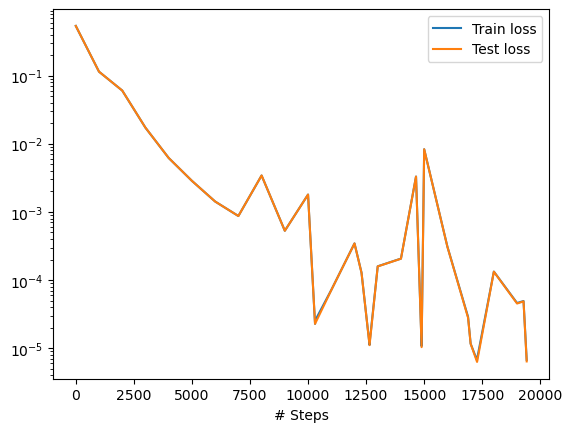

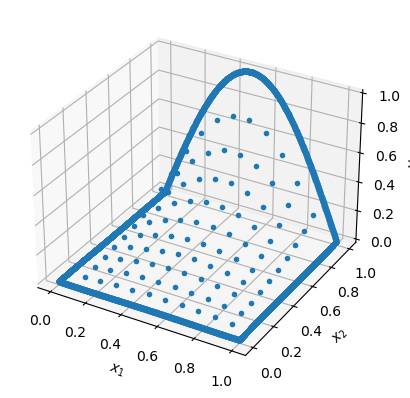

NameError: name 'gen_testdata' is not defined

In [26]:
X = geom.random_points(100000)
err = 1
while err > 0.005:
    f = model.predict(X, operator=pde)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile("adam", lr=1e-3)
    model.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    model.compile("L-BFGS")
    losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [30]:
u_pred = model.predict(points.T)
print("L2 relative error:", dde.metrics.l2_relative_error(u_exact, u_pred.reshape(100,100)))

L2 relative error: 0.0017489211115602555


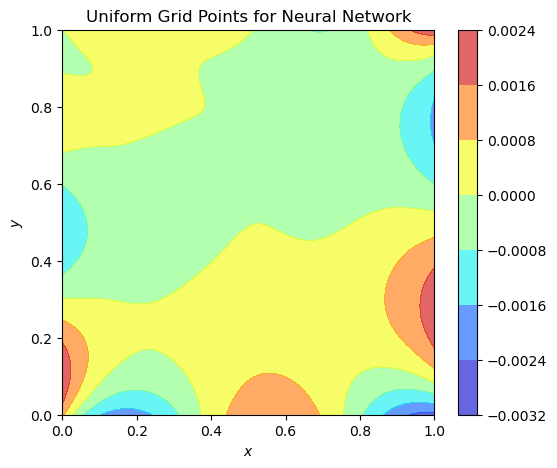

In [31]:
plt.figure(figsize=(6,5))

plt.contourf(plot_grid[0], plot_grid[1], u-u_exact, cmap='jet', alpha=0.6)

plt.xlabel('$x$')
plt.ylabel('$y$')
#plt.tick_params(left = False, right = False , labelleft = False, 
                #labelbottom = False, bottom = False)
plt.title('Uniform Grid Points for Neural Network');
plt.colorbar()